# Get the Data

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

In [188]:
import tensorflow as tf
#from tensorflow import keras
import keras
print(tf.__version__)
print(keras.__version__)

2.16.1
3.0.5


## Define global constants

In [189]:
MY_OPTIMIZER = "Adam"
MY_EPOCHS = 25
#MY_LEARNING_RATE = 0.1

# Get the Data

In [190]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()
maneuvers.shape

(538, 8)

In [191]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,5.380000e+02
mean,941.243303,-0.990423,0.000017,-0.000167,0.000011,-0.000017,-0.000008,1.582748e-11
std,544.944792,0.001021,0.003214,0.000709,0.002140,0.006606,0.001464,2.083377e-11
min,0.000000,-0.991665,-0.004521,-0.001121,-0.003245,-0.009033,-0.002051,-1.546545e-11
25%,470.621651,-0.991455,-0.003192,-0.000872,-0.001964,-0.006552,-0.001494,-9.534182e-13
50%,941.243303,-0.990581,0.000101,-0.000221,0.000025,-0.000425,-0.000049,9.437092e-12
75%,1411.864954,-0.989394,0.003265,0.000532,0.001990,0.006421,0.001465,3.171358e-11
max,1882.486606,-0.988843,0.004521,0.000898,0.003246,0.009931,0.002051,6.628074e-11


## Add/Drop Features

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [192]:
#maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)


# Prepare the Data for Machine Learning Algorithms

In [193]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers[["dv_st"]].copy()


# Convert dataframe to a numpy array before training, to avoid issues with dataframe headers.
maneuvers_predictors = maneuvers_predictors.to_numpy()
maneuvers_labels = maneuvers_labels.to_numpy()

#maneuvers_predictors.head()
#maneuvers_labels.head()

## Create a Train/Test/Validation Set

In [194]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
#X_train.head()

(322, 6)
(108, 6)
(108, 6)


In [195]:
# Scale all the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5]

array([[0.42217856, 0.99662169, 0.41140007, 0.98431628, 0.42073169,
        0.01901833],
       [0.60020336, 0.95468979, 0.267258  , 0.99594396, 0.27811575,
        0.07742765],
       [0.41916667, 0.00306673, 0.41404645, 0.01646862, 0.4233159 ,
        0.98173812],
       [0.96680092, 0.6488157 , 0.02015314, 0.68843424, 0.02175641,
        0.36955151],
       [0.03518632, 0.78694666, 0.89813121, 0.62712606, 0.89442379,
        0.16406953]])

In [196]:
# Scale target variable dv_st as well.
# Rationale: dv_st takes very small values (10^{-8}), 
# so MSE may be tiny and not computed properly. Also, NN may converge faster?

scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train)
y_valid_scaled = scaler_target.transform(y_valid)
y_test_scaled = scaler_target.transform(y_test)

In [197]:
import joblib
joblib.dump(scaler, 'scaler.gz')
joblib.dump(scaler_target, 'scaler_target.gz')

['scaler_target.gz']

# Building, Training, and Evaluating the Model

The output layer has a single neuron (since we only want to
predict a single value) and uses no activation function, and the loss function is the mean squared error. 

Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting.

In [198]:
model = keras.models.Sequential([
keras.layers.Dense(300, activation="relu", input_shape=X_train_scaled.shape[1:]),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(1)
])
model.summary()

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 300)            │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,301 (126.18 KB)

 Trainable params: 32,301 (126.18 KB)

 Non-trainable params: 0 (0.00 B)

In [199]:
model.compile(loss="mean_squared_error", optimizer=MY_OPTIMIZER)
history = model.fit(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS, 
                    validation_data=(X_valid_scaled, y_valid_scaled))

Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0588 - val_loss: 0.0210
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257 - val_loss: 0.0182
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0176 - val_loss: 0.0121
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 - val_loss: 0.0108
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0100
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0085
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - val_loss: 0.0072
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - val_loss: 0.0068
Epoch 9/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - val_loss: 0.0071
Epoch 10/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0064
Epoch 11/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - val_loss: 0.0066
Epoch 12/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_l

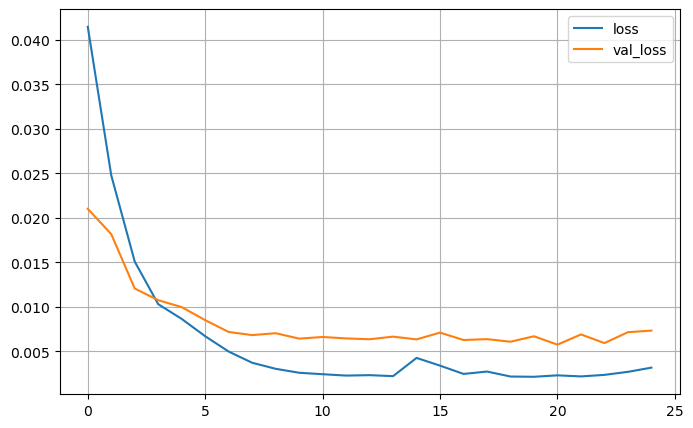

In [200]:
# Plot learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 5e-4) # set the vertical range to [0-1]
plt.show()

In [201]:
mse_test = model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 


0.055169740278662456

In [202]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [203]:
y_test_scaled[:3]

array([[0.42393958],
       [0.78976306],
       [0.20263619]])

In [204]:
y_pred[:3]

array([[0.44856063],
       [0.8341955 ],
       [0.24049255]], dtype=float32)

# Fine-Tuning Neural Network Hyperparameters

Wrap our Keras models in objects that mimic regular Scikit-Learn regressors.

def build_model(n_hidden, n_neurons, learning_rate, 
                input_shape):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", 
                                     **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

from scikeras.wrappers import KerasRegressor

keras_reg = KerasRegressor(build_model, n_hidden=1, n_neurons=30, learning_rate=3e-3, 
                input_shape=[8])

In [205]:
import keras
from keras import layers


def build_model(hp):
    model = keras.Sequential()
    #model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
               # Tune number of units separately for each layer.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
    model.add(layers.Dense(1))
    #learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        #optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        optimizer=MY_OPTIMIZER,
        loss="mean_squared_error",
    )
    return model


In [206]:
# Quickly test if model builds successfuly
import keras_tuner

build_model(keras_tuner.HyperParameters())

<Sequential name=sequential_2, built=False>

Use a randomized search to train hundreds of hyperparameter combinations  and see which one performs best on the validation set.

Note that RandomizedSearchCV uses K-fold cross-validation, so it
does not use X_valid and y_valid_scaled . These are just used for early stopping.

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, 
                                   n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train_scaled, epochs=100,
                  validation_data=(X_valid, y_valid_scaled),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [207]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [208]:
# print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


Then, start the search for the best hyperparameter configuration. All the arguments passed to search is passed to model.fit() in each execution. Remember to pass validation_data to evaluate the model.

In [209]:
tuner.search(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS, validation_data=(X_valid_scaled, y_valid_scaled))

Trial 20 Complete [00h 00m 06s]
val_loss: 0.005647489568218589

Best val_loss So Far: 0.005043427925556898
Total elapsed time: 00h 01m 49s


## Query the results
When search is over, you can retrieve the best model(s). The model is saved at its best performing epoch evaluated on the validation_data.

In [210]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 448)            │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 480)            │       215,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 160)            │        76,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 416)            │        66,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           417 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,009 (1.38 MB)

 Trainable params: 363,009 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [211]:
tuner.results_summary()

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 12 summary
Hyperparameters:
num_layers: 4
units_0: 448
units_1: 480
units_2: 160
units_3: 416
units_4: 224
Score: 0.005043427925556898

Trial 17 summary
Hyperparameters:
num_layers: 5
units_0: 416
units_1: 288
units_2: 128
units_3: 416
units_4: 512
Score: 0.005086838500574231

Trial 04 summary
Hyperparameters:
num_layers: 5
units_0: 288
units_1: 128
units_2: 32
units_3: 192
units_4: 480
Score: 0.0051314933225512505

Trial 03 summary
Hyperparameters:
num_layers: 5
units_0: 96
units_1: 192
units_2: 96
units_3: 480
units_4: 416
Score: 0.0052189265843480825

Trial 06 summary
Hyperparameters:
num_layers: 5
units_0: 320
units_1: 256
units_2: 160
units_3: 32
units_4: 96
Score: 0.005276046926155686

Trial 07 summary
Hyperparameters:
num_layers: 5
units_0: 480
units_1: 224
units_2: 128
units_3: 224
units_4: 192
Score: 0.005284621845930815

Trial 11 summary
Hyperparameters:
num_

In [212]:
mse_test = best_model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 


0.04097547013060421

In [213]:
X_new = X_test_scaled[:10] # pretend these are new instances
y_pred = best_model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [214]:
y_test_scaled[:10]

array([[0.42393958],
       [0.78976306],
       [0.20263619],
       [0.30474752],
       [0.09086202],
       [0.77596859],
       [0.02346245],
       [0.26091977],
       [0.35850357],
       [0.37192891]])

In [215]:
y_pred[:10]

array([[0.44876513],
       [0.78339124],
       [0.24298583],
       [0.34329143],
       [0.1186538 ],
       [0.6669083 ],
       [0.06522501],
       [0.26622644],
       [0.33546695],
       [0.39496586]], dtype=float32)

In [216]:
best_model.save("best_model.keras")

In [217]:
X = maneuvers_predictors[:1]
print(X)

[[-9.91362725e-01  3.70643955e-03  4.21154862e-04  1.65143321e-03
   5.40204024e-03 -1.85108489e-03]]


In [218]:
X_scaled = scaler.transform(X)
print(X_scaled)

[[0.10699571 0.90990836 0.76375648 0.7544113  0.76125807 0.04878838]]


In [219]:
y_scaled = best_model.predict(X_scaled)
print(y_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[[0.82908964]]


In [220]:
dv = scaler_target.inverse_transform(y_scaled)
print(dv)

[[5.2309466e-11]]


In [221]:
y = maneuvers_labels[:1]
print(y)

[[-3.55630182e-12]]


In [222]:
y_scaled = scaler_target.transform(y)
print(y_scaled)

[[0.14568444]]
